# Run Analysis

The experiment I had aims to answer the question: does Directional Change (DC) target tranformation help improve model performance in univariate time series forecasting? The experiment goes as the following:

1. I took some models with forecasting abilities
  - a linear regression model: Elastic Net (`EN`)
  - tree-based regressors: Random Forest regressor (`RF`), Light GBM regressor (`LGBM`)
  - a kernel methods: Linear Support Vector regressor (`LSVR`)
  - a neural network regressor: Multi-layer perceptron regressor (`MLP`)
  - a statistical forecasting model: Exponential Smoothing forecaster (`ETS`)
  - a naive forecaster as benchmark: moving average with q=1 (`MA`)

2. And then I set up agents with different combination of methodologies. For a model `MODEL` listed above, there could be three types of agents:

  - `MODEL_raw`: agent uses model `MODEL` and with log-difference target transformation
  - `MODEL_l_tran`: agent uses model `MODEL`, log-difference and DC target transformation with linear interpolation
  - `MODEL_a_tran`: agent uses model `MODEL`, log-difference and DC target transformation with Akima interpolation

3. I had the agents played (trained and forecasted) on 50 univariate daily financial time series I took from the m4 competition dataset.
4. For every time series played, I calulated the Symmetric Mean Absolute Error (SMAPE) score to use as a performance measure.
5. I gathered the SMAPE for all the agents (should be 50 SMAPEs for each agent) and compare them.
6. The goal is to observe that for the agent using the same model, the one with DC tranformation does better than the one without.

This notebook analyze the information generated by the experiment I had for **m4 daily financial dataset**. There are two remarks to the configuration:

- log-return target transformation is applied after DC transformation
- There are two versions of MA, with and without log-difference transformation. The ordinary MA is with log-differencing (`MA`), and `MA(x ld)` is the one without.

Other information about the run:

- a total of 50 time series are run, average length = 1218.54
- validation size = 10 percent of the dataset
- test size = 10 percent of the dataset
- gap = 0 (one step ahead forecasting)
- horiozn = 1 (point forecasting)
- trained, validated and tested with expanding window technique
- the step size of the expanding window is 1
- retrain window = 10 (models are re-fitted every 10 steps)
- models are provided with the choice of using 7, 14, or 21 latest observations. This serves as a hyperparameter introducing the autoregressive feature to the models.
- models involved are MA(naive on raw data), MA(naive on log-differenced data), EN, MLP, RF, LGBM, ETS, and LSVR

In [1]:
import os
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from pprint import pprint

plt.rcParams['figure.figsize'] = (20, 8)
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

Load run information

In [2]:
plt.style.use('seaborn')

In [3]:
runs = ['13-07-2022--18-20-12', '14-07-2022--10-28-15', '14-07-2022--19-47-45', '15-07-2022--10-05-15']

run_infos = []

for run in runs:
    with open(f'{run}/run_info.json', 'r') as file:
        run_infos.append(json.load(file))

pprint(run_infos)

[{'Avg. len of series': 1218.54,
  'config input': {'dataset': {'cumulate used': 0,
                               'file name': 'm4_daily_finance.json',
                               'file path': 'datasets/',
                               'file type': 'json',
                               'max length': 1500,
                               'min length': 1000,
                               'use series': 50},
                   'execution config': {'n of workers': 22},
                   'modelling config': {'forecast horizon': 1,
                                        'gap': 0,
                                        'retrain window': 10,
                                        'score measure': 'SMAPE',
                                        'test size': 0.1,
                                        'validation size': 0.1},
                   'models': ['MA', 'EN', 'MLP', 'LSVR', 'RF', 'LGBM', 'ETS'],
                   'transformation config': {'interp kind': ['akima'],
           

Load agents' run information

In [4]:
agent_infos_raw = {}
l_not_log_diff_count = 0
a_not_log_diff_count = 0
a_log_diff_count = 0
l_log_diff_count = 0

for i, run in enumerate(run_infos):
    run_id = run['run time'][0]
    models = run['config input']['models']
    
    if run_id == '14-07-2022--10-28-15':
        for m in models:
            agent_1 = f'{m}(x ld)_raw'
            agent_2 = f'{m}(x ld)_a_tran'

            if a_not_log_diff_count == 0:
                with open(f'{run_id}/MA_raw.json', 'r') as file:
                    agent_infos_raw[agent_1] = json.load(file)
                with open(f'{run_id}/MA_tran.json', 'r') as file:
                    agent_infos_raw[agent_2] = json.load(file)
            else:
                with open(f'{run_id}/MA_raw.json', 'r') as file:
                    agent_infos_raw[agent_1] = {**agent_infos_raw[agent_1], **json.load(file)}
                with open(f'{run_id}/MA_tran.json', 'r') as file:
                    agent_infos_raw[agent_2] = {**agent_infos_raw[agent_2], **json.load(file)}

        a_not_log_diff_count += 1
        continue

    if run_id == '15-07-2022--10-05-15':
        for m in models:
            agent_2 = f'{m}(x ld)_l_tran'

            if l_not_log_diff_count == 0:
                with open(f'{run_id}/MA_tran.json', 'r') as file:
                    agent_infos_raw[agent_2] = json.load(file)
            else:
                with open(f'{run_id}/MA_tran.json', 'r') as file:
                    agent_infos_raw[agent_2] = {**agent_infos_raw[agent_2], **json.load(file)}

        l_not_log_diff_count += 1
        continue

    if run_id == '14-07-2022--19-47-45':
        for m in models:
            agent_2 = f'{m}_tran'

            if l_log_diff_count == 0:
                with open(f'{run_id}/{agent_2}.json', 'r') as file:
                    agent_2 = f'{m}_l_tran'
                    agent_infos_raw[agent_2] = json.load(file)

            else:
                with open(f'{run_id}/{agent_2}.json', 'r') as file:
                    agent_2 = f'{m}_l_tran'
                    agent_infos_raw[agent_2] = {**agent_infos_raw[agent_2], **json.load(file)}
        
        l_log_diff_count += 1
        continue



    for m in models:
        agent_1 = f'{m}_raw'
        agent_2 = f'{m}_tran'

        if a_log_diff_count == 0:
            with open(f'{run_id}/{agent_1}.json', 'r') as file:
                agent_infos_raw[agent_1] = json.load(file)
            with open(f'{run_id}/{agent_2}.json', 'r') as file:
                agent_2 = f'{m}_a_tran'
                agent_infos_raw[agent_2] = json.load(file)
        else:
            with open(f'{run_id}/{agent_1}.json', 'r') as file:
                agent_infos_raw[agent_1] = {**agent_infos_raw[agent_1], **json.load(file)}
            with open(f'{run_id}/{agent_2}.json', 'r') as file:
                agent_2 = f'{m}_a_tran'
                agent_infos_raw[agent_2] = {**agent_infos_raw[agent_2], **json.load(file)}
    a_log_diff_count += 1


A list of agents we have in this analysis.

In [5]:
agent_infos_raw = dict( sorted(agent_infos_raw.items(), key=lambda x: x[0].lower()) )

list(agent_infos_raw.keys())

['EN_a_tran',
 'EN_l_tran',
 'EN_raw',
 'ETS_a_tran',
 'ETS_l_tran',
 'ETS_raw',
 'LGBM_a_tran',
 'LGBM_l_tran',
 'LGBM_raw',
 'LSVR_a_tran',
 'LSVR_l_tran',
 'LSVR_raw',
 'MA(x ld)_a_tran',
 'MA(x ld)_l_tran',
 'MA(x ld)_raw',
 'MA_a_tran',
 'MA_l_tran',
 'MA_raw',
 'MLP_a_tran',
 'MLP_l_tran',
 'MLP_raw',
 'RF_a_tran',
 'RF_l_tran',
 'RF_raw']

Check if all time series have been played successfully. Exclude those which not all agents have played successfully.

In [6]:
agent_fails = {k: [] for k in agent_infos_raw.keys()}
series_excluded = []

for agent, plays in agent_infos_raw.items():
    for series, info in plays.items():
        if info['message'] != None:
            agent_fails[agent].append(series)
            series_excluded.append(series)

if not series_excluded:
    print('All agents have successfully ran on all series.')
else:
    print(series_excluded)
    print(agent_fails)

All agents have successfully ran on all series.


Get analysis only on the series played by all agents.

In [7]:
played = [set(plays.keys()) for plays in agent_infos_raw.values()]
played_by_all = played[0].intersection(*played[1:])
print('Series played by all agents: ')
print(played_by_all)

Series played by all agents: 
{'2517', '2526', '2045', '2485', '2595', '2370', '2621', '2591', '2317', '2753', '2044', '2040', '2575', '2503', '2589', '2432', '2310', '2578', '2081', '2080', '2518', '2580', '2497', '2590', '2425', '2137', '2516', '2755', '2483', '2078', '2622', '2588', '2553', '2592', '2754', '2625', '2214', '2502', '2440', '2439', '2484', '2577', '2624', '2623', '2315', '2292', '2576', '2041', '2551', '2552'}


In [8]:
dict_filter = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y) ]) # large, filter keys

agent_infos = {agent: dict_filter(plays, played_by_all) for agent, plays in agent_infos_raw.items()}

## Statistics of overall performance

In this section, we calculate some statistics that concludes the general performance of each agent over the time series played.

In addition to SMAPE, we compute the ranking of each agent per time series. So each agent will have a ranking for a time series, ranging from 1 to the number of agent involved. I store this ranking info to the `agent_infos` dictionary, as how SMAPE is stored for each agent per time series.

In [9]:
for agent, plays in agent_infos.items():
    for series, play_info in plays.items():
        score = play_info['test SMAPE']
        lower = [1 for a in agent_infos.keys() if agent_infos[a][series]['test SMAPE']-score < 0]
        play_info['ranking'] = sum(lower) + 1

In [10]:
numbers = {
    agent: {
        'SMAPEs': [],
        'rankings': []
    } for agent in agent_infos
}

stats = {
    agent: {
        'mean SMAPE': None,
        'std. SMAPE': None,
        'mean ranking': None,
        'std. ranking': None
    } for agent in agent_infos
}

for agent, plays in agent_infos.items():
    for series, play_info in plays.items():
        numbers[agent]['SMAPEs'].append(play_info['test SMAPE'])
        numbers[agent]['rankings'].append(play_info['ranking'])
    
    stats[agent]['mean SMAPE'] = np.mean(numbers[agent]['SMAPEs'])
    stats[agent]['std. SMAPE'] = np.std(numbers[agent]['SMAPEs'])
    stats[agent]['mean ranking'] = np.mean(numbers[agent]['rankings'])
    stats[agent]['std. ranking'] = np.std(numbers[agent]['rankings'])

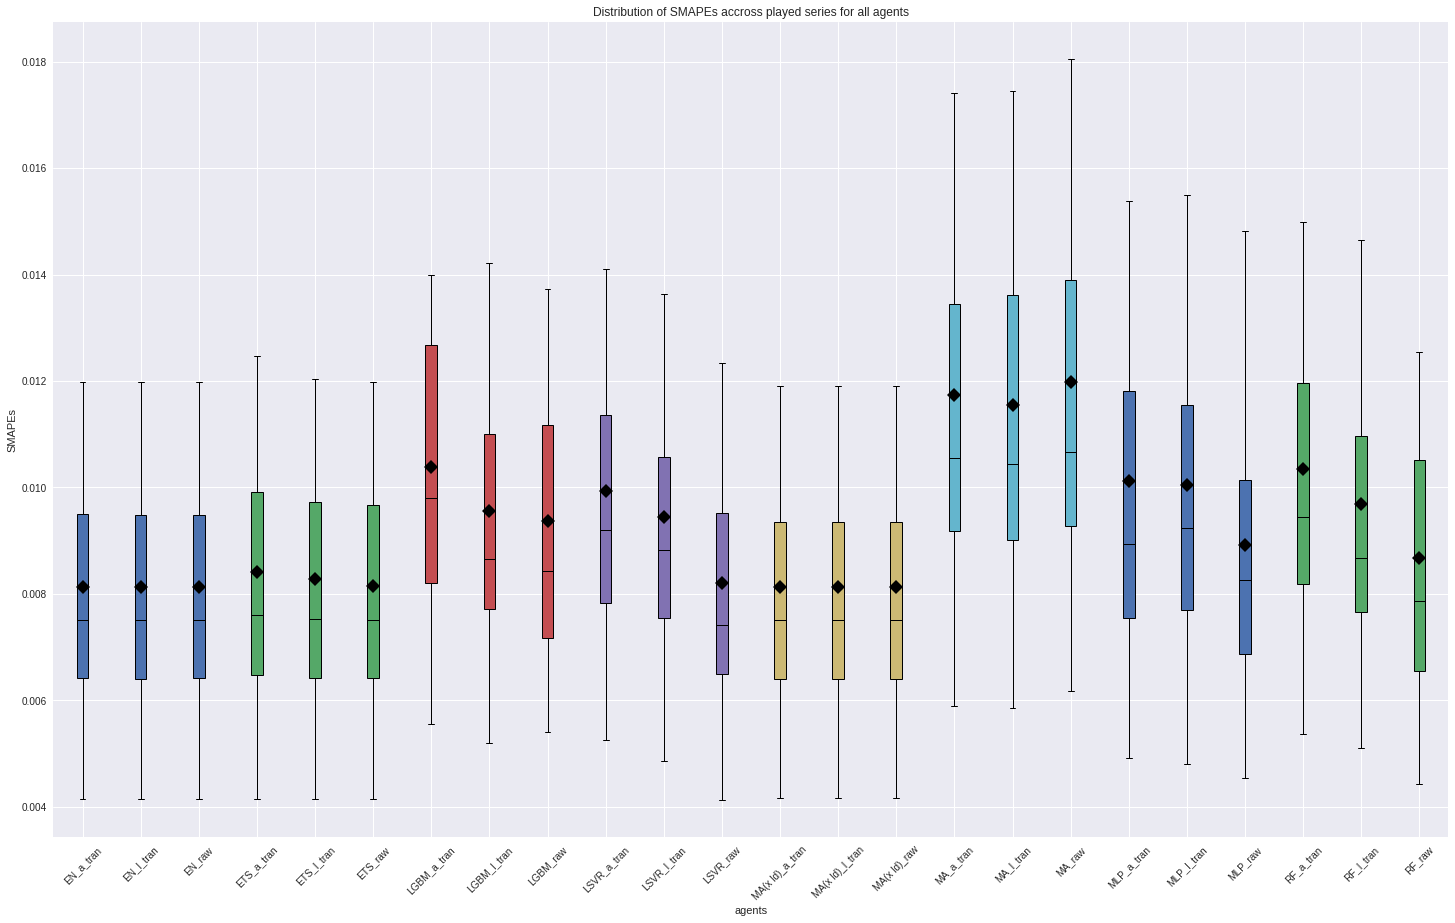

In [11]:
plt.figure(figsize= (25, 15))
n_agents = len(list(numbers.keys()))
colors = [f'C{i}' for i in range(n_agents//3)]
meanprop = dict(marker='D', markerfacecolor='black', markersize=10)

boxes = []
labels = []
for agent, box in numbers.items():
    boxes.append(box['SMAPEs'])
    labels.append(agent)

box = plt.boxplot(
    boxes,
    showbox=True,
    showfliers=False,
    labels=labels,
    widths=0.2,
    showmeans=True,
    meanprops=meanprop,
    patch_artist=True)

for i, patch in enumerate(box['boxes']):
    c = i // (n_agents//(n_agents//3))
    patch.set_facecolor(colors[c])
    box['medians'][i].set_color('k')

plt.title(f'Distribution of SMAPEs accross played series for all agents')
plt.xlabel('agents')
plt.ylabel('SMAPEs')
plt.xticks(rotation=45)
plt.show()

## Ranking of the agents

In this section, treating the ranking of the agents as a variable, we compute the alpha-confidence interval of the rankings for the agents.

In [12]:
series_ran = agent_infos['MLP_raw'].keys()
n_series_ran = len(series_ran)

alpha = 0.1
Q = len(list(agent_infos.keys()))
P = n_series_ran
dist = np.random.standard_normal(size=Q)
r_lower, r_upper = np.min(dist), np.max(dist)
qrange = list(np.arange(r_lower, r_upper, step=(r_upper-r_lower)/100))
q_alpha_Q = qrange[-int(alpha*100)]

def conf_limit(Q, P, mean_R, q_alpha_Q):
    stat = 0.5 * q_alpha_Q * np.sqrt(Q*(Q+1)/(12 * P))
    return round(mean_R-stat, 6), round(mean_R+stat, 6)

for agent in agent_infos.keys():
    stats[agent][f'{100-int(alpha*100)}% ranking confi. limits'] = conf_limit(Q, P, stats[agent]['mean ranking'], q_alpha_Q)

leaderboard = pd.DataFrame(stats)
leaderboard

,EN_a_tran,EN_l_tran,EN_raw,ETS_a_tran,ETS_l_tran,ETS_raw,LGBM_a_tran,LGBM_l_tran,LGBM_raw,LSVR_a_tran,...,MA(x ld)_raw,MA_a_tran,MA_l_tran,MA_raw,MLP_a_tran,MLP_l_tran,MLP_raw,RF_a_tran,RF_l_tran,RF_raw
mean SMAPE,0.008129,0.008129,0.008129,0.008404,0.008284,0.008149,0.010389,0.009552,0.009363,0.009928,...,0.008126,0.01174,0.011551,0.011975,0.010128,0.010044,0.008918,0.010352,0.009691,0.008668
std. SMAPE,0.002736,0.002736,0.002735,0.002817,0.002783,0.002748,0.003797,0.003146,0.003227,0.003408,...,0.002733,0.004411,0.004273,0.004624,0.004259,0.004007,0.003372,0.003774,0.003443,0.003185
mean ranking,4.72,4.6,4.6,8.38,7.12,5.44,19.18,15.38,14.68,17.66,...,3.42,22.84,22.0,23.66,17.16,17.26,12.36,19.24,15.96,10.88
std. ranking,2.172924,1.939072,2.209072,4.417646,3.253552,2.272972,2.405743,2.591447,2.949169,1.903786,...,2.585266,0.783837,0.663325,0.62,2.830972,2.606223,2.406325,1.83913,2.78539,3.076622
90% ranking confi. limits,"(3.839764, 5.600236)","(3.719764, 5.480236)","(3.719764, 5.480236)","(7.499764, 9.260236)","(6.239764, 8.000236)","(4.559764, 6.320236)","(18.299764, 20.060236)","(14.499764, 16.260236)","(13.799764, 15.560236)","(16.779764, 18.540236)",...,"(2.539764, 4.300236)","(21.959764, 23.720236)","(21.119764, 22.880236)","(22.779764, 24.540236)","(16.279764, 18.040236)","(16.379764, 18.140236)","(11.479764, 13.240236)","(18.359764, 20.120236)","(15.079764, 16.840236)","(9.999764, 11.760236)"


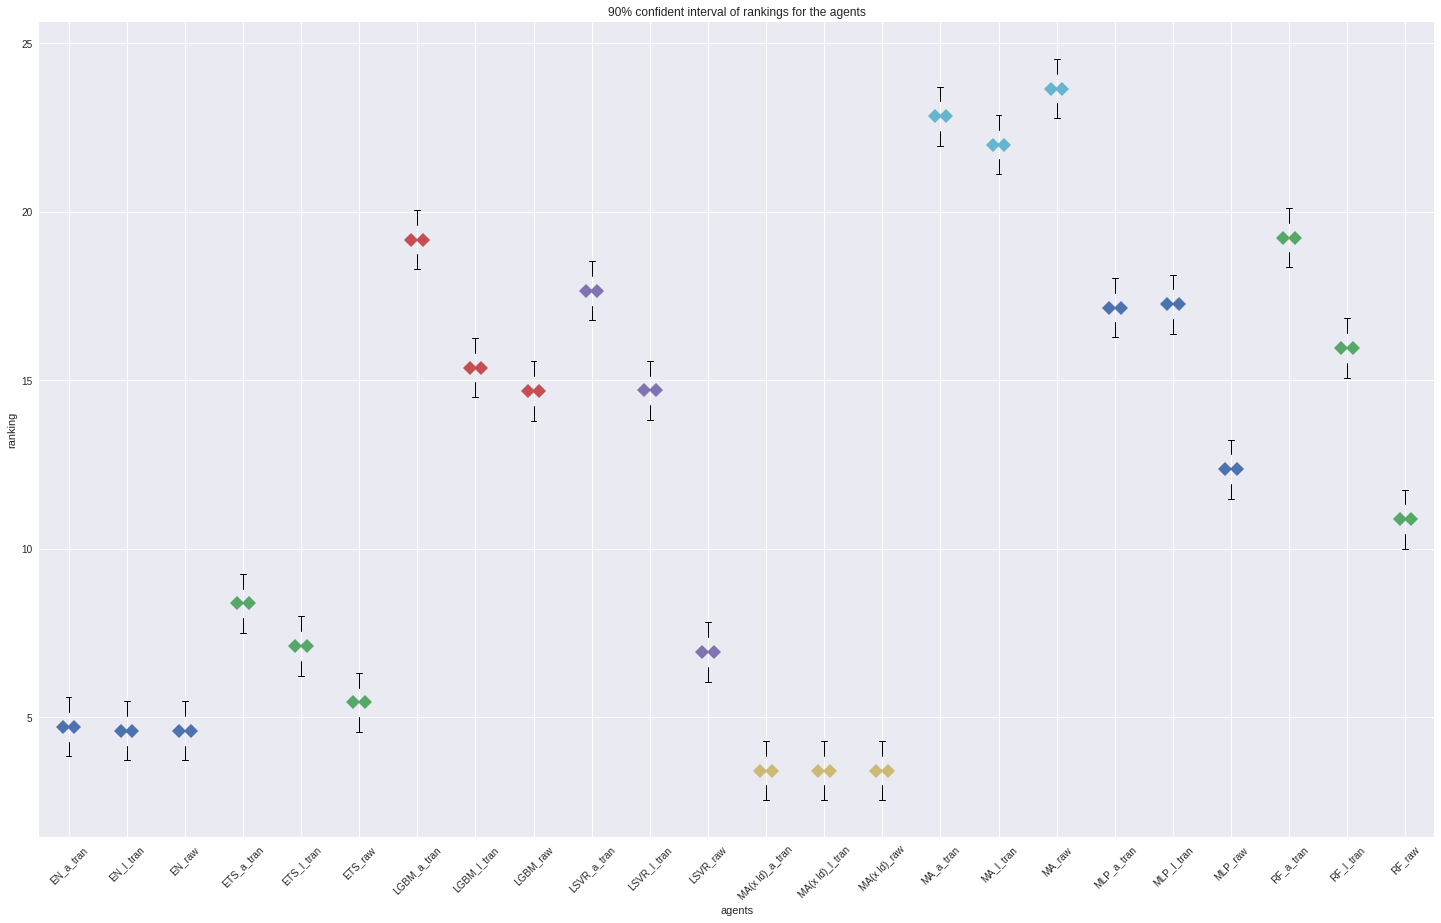

In [13]:
n_agents = len(list(numbers.keys()))
colors = [f'C{i}' for i in range(n_agents//3)]
medianprop = dict(marker='D', markersize=10)
plt.figure(figsize= (25, 15))
box = plt.boxplot(
    [
        [
            agent[f'{100-int(alpha*100)}% ranking confi. limits'][0],
            agent['mean ranking'],
            agent[f'{100-int(alpha*100)}% ranking confi. limits'][1]
        ] for agent in stats.values()
    ],
    showbox=False,
    labels=list(numbers.keys()),
    widths=0.2,
    medianprops=medianprop,
    patch_artist=True)

for i, patch in enumerate(box['medians']):
    c = i // (n_agents//(n_agents//3))
    patch.set_color(colors[c])

plt.title(f'{100-int(alpha*100)}% confident interval of rankings for the agents')
plt.xlabel('agents')
plt.ylabel('ranking')
plt.xticks(rotation=45)
plt.show()

## Fraction best

In this section, we compute another performance measure, called the fraction-best measure. Building on our basis performance measure SMAPE, we compute how much of a fraction out of all played time series that a model beats all other models. This measure lets us know the potential of an agent being exceptionally good conditional on the given datasets.

The results are shown in the last row of the table.

In [14]:
for agent, play_info in stats.items():
    play_info['frac best'] = np.sum([1 for r in numbers[agent]['rankings'] if r == 1])/n_series_ran

leaderboard = pd.DataFrame(stats)
leaderboard

,EN_a_tran,EN_l_tran,EN_raw,ETS_a_tran,ETS_l_tran,ETS_raw,LGBM_a_tran,LGBM_l_tran,LGBM_raw,LSVR_a_tran,...,MA(x ld)_raw,MA_a_tran,MA_l_tran,MA_raw,MLP_a_tran,MLP_l_tran,MLP_raw,RF_a_tran,RF_l_tran,RF_raw
mean SMAPE,0.008129,0.008129,0.008129,0.008404,0.008284,0.008149,0.010389,0.009552,0.009363,0.009928,...,0.008126,0.01174,0.011551,0.011975,0.010128,0.010044,0.008918,0.010352,0.009691,0.008668
std. SMAPE,0.002736,0.002736,0.002735,0.002817,0.002783,0.002748,0.003797,0.003146,0.003227,0.003408,...,0.002733,0.004411,0.004273,0.004624,0.004259,0.004007,0.003372,0.003774,0.003443,0.003185
mean ranking,4.72,4.6,4.6,8.38,7.12,5.44,19.18,15.38,14.68,17.66,...,3.42,22.84,22.0,23.66,17.16,17.26,12.36,19.24,15.96,10.88
std. ranking,2.172924,1.939072,2.209072,4.417646,3.253552,2.272972,2.405743,2.591447,2.949169,1.903786,...,2.585266,0.783837,0.663325,0.62,2.830972,2.606223,2.406325,1.83913,2.78539,3.076622
90% ranking confi. limits,"(3.839764, 5.600236)","(3.719764, 5.480236)","(3.719764, 5.480236)","(7.499764, 9.260236)","(6.239764, 8.000236)","(4.559764, 6.320236)","(18.299764, 20.060236)","(14.499764, 16.260236)","(13.799764, 15.560236)","(16.779764, 18.540236)",...,"(2.539764, 4.300236)","(21.959764, 23.720236)","(21.119764, 22.880236)","(22.779764, 24.540236)","(16.279764, 18.040236)","(16.379764, 18.140236)","(11.479764, 13.240236)","(18.359764, 20.120236)","(15.079764, 16.840236)","(9.999764, 11.760236)"
frac best,0.1,0.06,0.1,0.1,0.06,0.08,0.0,0.0,0.0,0.0,...,0.36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02


In [15]:
print(leaderboard.iloc[-1, :])

EN_a_tran           0.1
EN_l_tran          0.06
EN_raw              0.1
ETS_a_tran          0.1
ETS_l_tran         0.06
ETS_raw            0.08
LGBM_a_tran         0.0
LGBM_l_tran         0.0
LGBM_raw            0.0
LSVR_a_tran         0.0
LSVR_l_tran         0.0
LSVR_raw           0.28
MA(x ld)_a_tran    0.36
MA(x ld)_l_tran    0.36
MA(x ld)_raw       0.36
MA_a_tran           0.0
MA_l_tran           0.0
MA_raw              0.0
MLP_a_tran          0.0
MLP_l_tran          0.0
MLP_raw             0.0
RF_a_tran           0.0
RF_l_tran           0.0
RF_raw             0.02
Name: frac best, dtype: object


: 

## Time series where the tranformation works

From the fraction best calculation, we now that there are specific cases where the tranformation beats untransformed agent. Let's pull those cases and see if we can find something useful there, e.g., characteristics of the time series.

We do two things here:

- for each model, find the time series where the transformation wins
- for all agents, find the time series where the winning agent uses tranformation

In [87]:
tran_works = {}
tran_wins = {}

for agent, plays in agent_infos.items():
    if 'MA' in agent: continue
    for play_id, play_infos in plays.items():
        if play_id not in tran_wins: tran_wins[play_id] = []
        if 'tran' in agent: 
            if play_infos['ranking'] == 1:
                tran_wins[play_id].append({
                    'winning agent': agent,
                    'play infos': play_infos
                })

        if tran_wins[play_id] == []: del tran_wins[play_id]

        ind = agent.index('_')
        m = agent[:ind]
        if play_id not in tran_works: tran_works[play_id] = []

        if '_l_tran' in agent:
            if play_infos['test SMAPE'] < agent_infos[f'{m}_raw'][play_id]['test SMAPE']:
                tran_works[play_id].append({
                    'winning agent': agent,
                    'play infos': play_infos
                })
        elif '_a_tran' in agent:
            if play_infos['test SMAPE'] < agent_infos[f'{m}_raw'][play_id]['test SMAPE']:
                tran_works[play_id].append({
                    'winning agent': agent,
                    'play infos': play_infos
                })
        
        if tran_works[play_id] == []: del tran_works[play_id]

In [88]:
list(tran_wins.keys())

['2040',
 '2370',
 '2432',
 '2551',
 '2580',
 '2483',
 '2484',
 '2552',
 '2621',
 '2754',
 '2440',
 '2526',
 '2576']

In [89]:
for k, v in tran_wins.items():
    n = len(v)
    for i in range(n):
        print(v[i]['winning agent'])

EN_a_tran
EN_l_tran
EN_a_tran
EN_a_tran
EN_l_tran
EN_a_tran
EN_a_tran
EN_l_tran
ETS_a_tran
ETS_a_tran
ETS_a_tran
ETS_a_tran
ETS_a_tran
ETS_l_tran
ETS_l_tran
ETS_l_tran


In [25]:
list(tran_works.keys())

['2041',
 '2078',
 '2137',
 '2315',
 '2425',
 '2439',
 '2440',
 '2483',
 '2484',
 '2526',
 '2551',
 '2575',
 '2590',
 '2592',
 '2624',
 '2625',
 '2552',
 '2754',
 '2081',
 '2588',
 '2621',
 '2370',
 '2485',
 '2576',
 '2595',
 '2622',
 '2214',
 '2292',
 '2502',
 '2080',
 '2432',
 '2517',
 '2553',
 '2577',
 '2580',
 '2623',
 '2753',
 '2040']

In [85]:
# the time series
with open('m4_daily_finance_50.json', 'r') as file:
    ts = json.load(file)

# 2551
# 2440 ets

use = '2576'

In [86]:
tran_wins[use]

{'winning agent': 'ETS_l_tran',
 'play infos': {'message': None,
  'test SMAPE': 0.007277,
  'val SMAPE': 0.007698,
  'best model': {'thres up': 0.01,
   'thres down': 0.21,
   'interp kind': 'linear',
   'use states': True,
   'auto': True},
  'y hats': [9875.579868870223,
   9795.395553818833,
   10150.66436491327,
   10230.647301759198,
   10138.848248938653,
   10018.620356958325,
   9969.067085813422,
   10001.699345479417,
   10011.407802022277,
   10084.48226605488,
   10261.967272104117,
   10340.749010980382,
   10264.966644751259,
   10252.251316428503,
   10271.97025131965,
   10368.570729218905,
   10481.589380512747,
   10598.412960786873,
   10711.333159902664,
   10606.21702801609,
   10336.827274017847,
   10669.681204630764,
   10783.202231666151,
   10824.44492399755,
   10766.379328273657,
   10812.927672425107,
   10922.044547756195,
   10829.841361852794,
   10922.540226602801,
   10997.419971821328,
   10991.010429353133,
   10984.40069190984,
   10795.59142839565

In [79]:
# filter out the test set

test_size = run_infos[0]['config input']['modelling config']['test size']
test_set_count = int(len(ts[use]['raw']) * test_size)

test_set = ts[use]['raw'][-(test_set_count):]

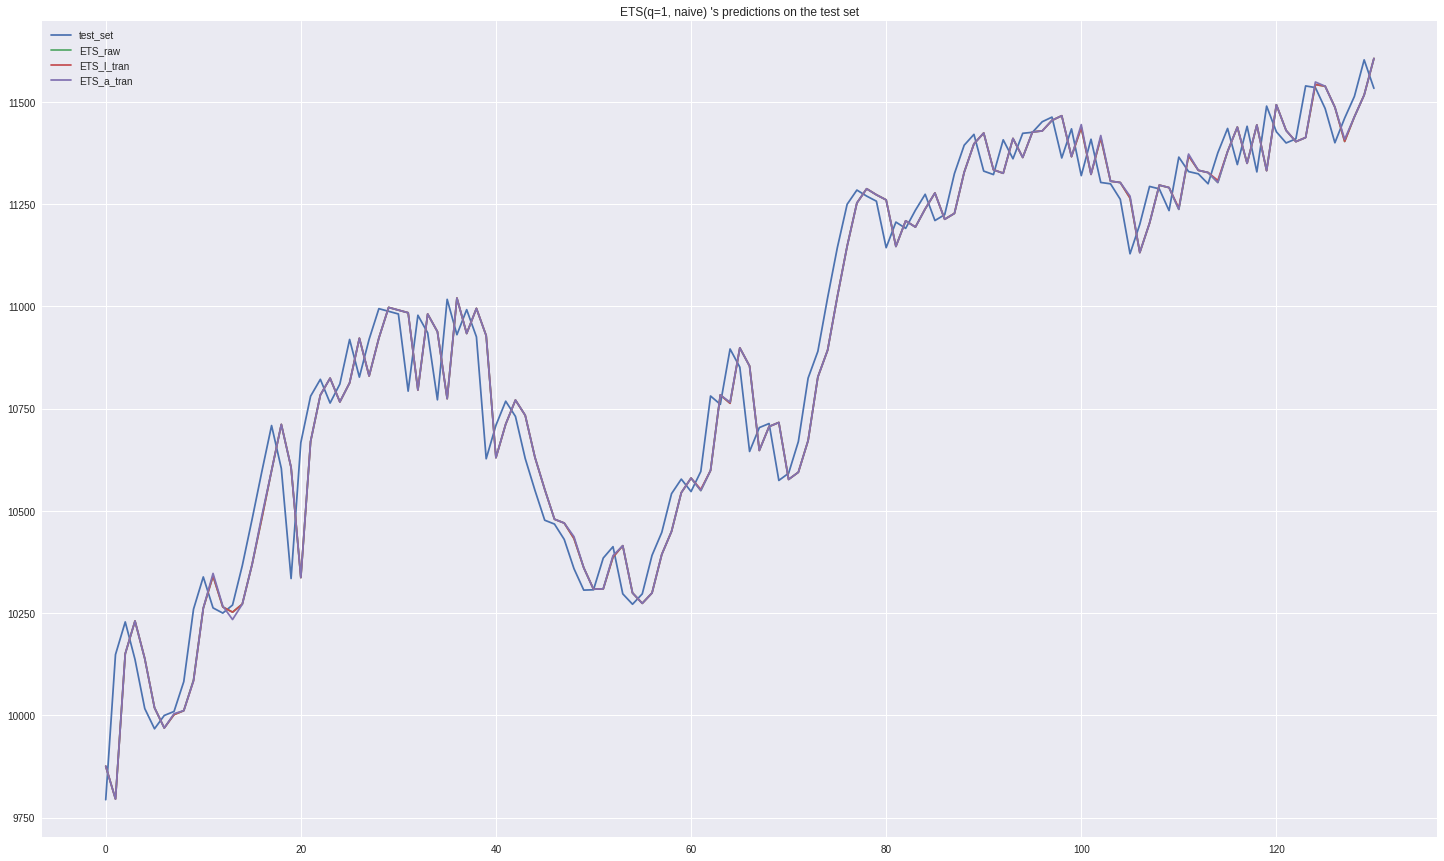

In [80]:
model = tran_wins[use]['winning agent']
ind = model.index('_')
model = model[:ind]
# inter_kind = agent_infos[f'{model}_tran'][use]['best model']['interp kind']

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_l_tran'][use]['y hats'], label=f'{model}_l_tran')
plt.plot(agent_infos[f'{model}_a_tran'][use]['y hats'], label=f'{model}_a_tran')
plt.title(f'{model}(q=1, naive) \'s predictions on the test set')
plt.legend()
plt.show()

## If DC were to choose and switch between Akima and linear interpolation...

In the previous comparison, we saw what will happen when DC always go for one of the two interpolation methods. Now let's see what will happen if DC was given the opportunity to choose one of them.

The way I come up with the number is:

- for agents without DC tranformation, their errors stay the same.
- for agents with DC transformation, for each time series played, I compare the error yield when applying Akima and Linear interpolation, and then take the lower one. This is essentially doing the validation manually to pick the better performing policy.

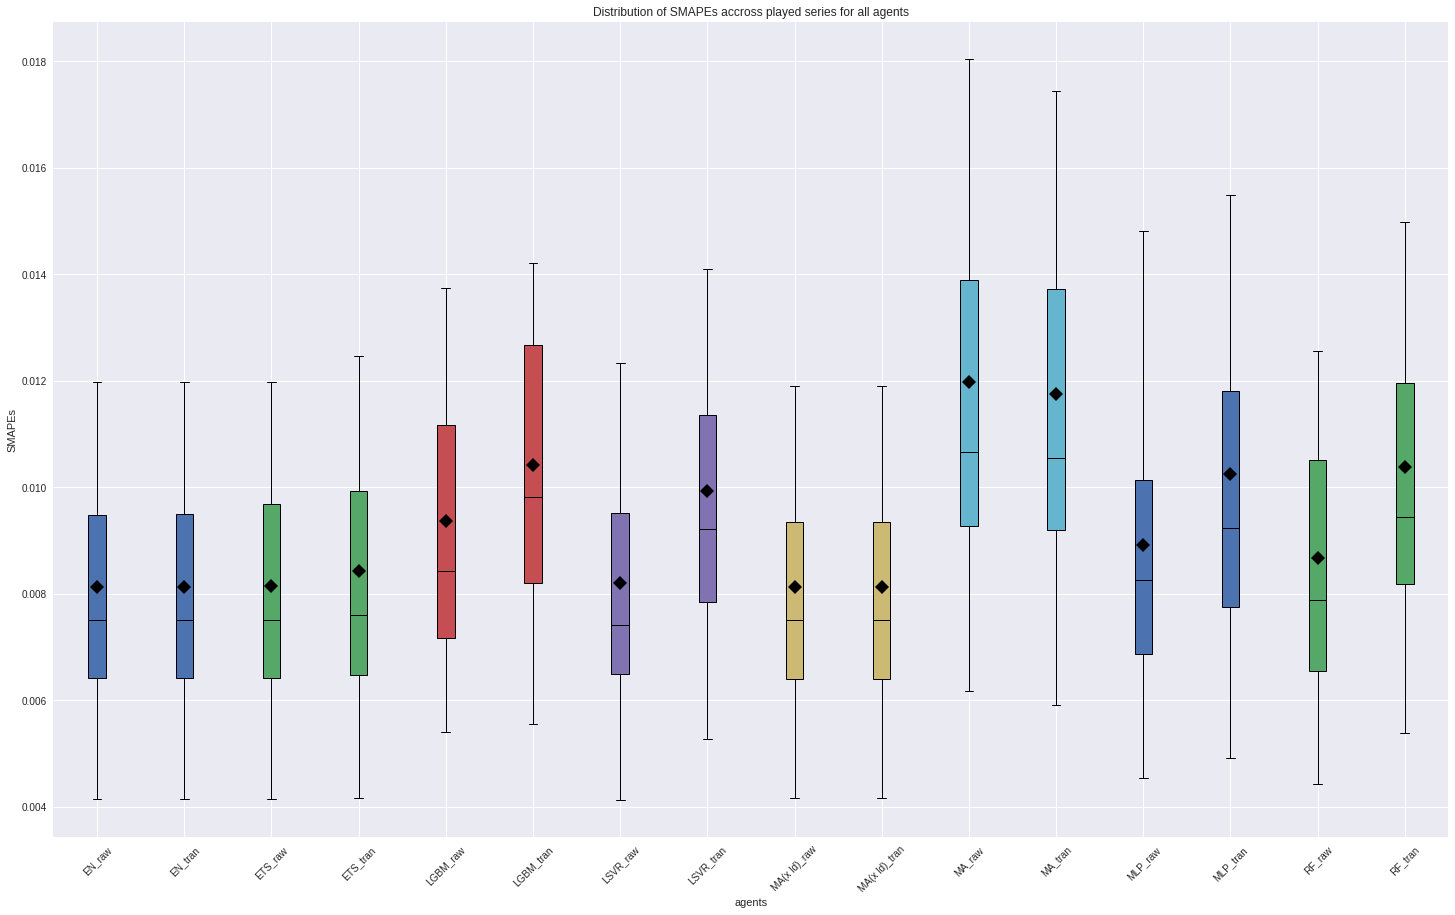

In [18]:
vals = {}
l_over_a_count = {}

for agent, number in numbers.items():
    if 'raw' in agent:
        vals[agent] = numbers[agent]['SMAPEs']
    elif '_a_tran' in agent:
        continue
    elif '_l_tran' in agent:
        ind = agent.index('_')
        m = agent[:ind]
        
        choice = []
        count = 0
        for l, a in zip(numbers[f'{m}_l_tran']['SMAPEs'], numbers[f'{m}_a_tran']['SMAPEs']):
            choice.append(np.max((l, a)))
            if l <= a:
                count += 1
        
        l_over_a_count[f'{m}_tran'] = count
        vals[f'{m}_tran'] = choice

vals = dict( sorted(vals.items(), key=lambda x: x[0].lower()) )

plt.figure(figsize= (25, 15))
n_agents = len(list(numbers.keys()))
colors = [f'C{i}' for i in range(n_agents//3)]
meanprop = dict(marker='D', markerfacecolor='black', markersize=10)

box = plt.boxplot(
    list(vals.values()),
    showbox=True,
    showfliers=False,
    labels=list(vals.keys()),
    widths=0.2,
    showmeans=True,
    meanprops=meanprop,
    patch_artist=True)

for i, patch in enumerate(box['boxes']):
    c = i // (n_agents//(n_agents//2))
    patch.set_facecolor(colors[c])
    box['medians'][i].set_color('k')

plt.title(f'Distribution of SMAPEs accross played series for all agents')
plt.xlabel('agents')
plt.ylabel('SMAPEs')
plt.xticks(rotation=45)
plt.show()

Out of 50 time series played, most of the agents went for linear interpolation.

In [36]:
print(f'Number of time Linear interpolation is chosen over Akima out of {n_series_ran} time series played.')
pprint(l_over_a_count)

Number of time Linear interpolation is chosen over Akima out of 50 time series played.
{'EN_tran': 36,
 'ETS_tran': 36,
 'LGBM_tran': 44,
 'LSVR_tran': 45,
 'MA(x ld)_tran': 50,
 'MA_tran': 43,
 'MLP_tran': 21,
 'RF_tran': 44}


# Feature importance analysis

In this section, we investigate the parameters estimated by the machine learning models to gain more insights on how the models learn the problems. We use a heatmap to visualise the parameters. For each heatmap, the x-axis shows the features available to the agent and the y-axis shows the time series ran by the agent. The color in correspond to the bar to the right indicates the corresponding estimates by the model. We go through

- feature importance reported by the tree-based models (RF, LGBM)
- coefficients estimated by the linear regression model (EN)

As to the features accessible for the agents, the maximum number of lags is 21. In addition, in the way I designed the DC transformation, DC is able to provide a `state` feature. This variable `state` is a categorical variable that basically say what state has the DC algorithm identified the input data point as. There are 8 possible states for the `state` variable. I thus one-hot encoded the `state` feature into 8 features.

And obviously, only for agents involving DC transformation are able to access the state features. Hence `MODEL_raw` agents should have estimates of the state features be 0.

In [38]:
# find out the maximum number of lags possible
max_n_lag = 21
states = True
if states:
    n_states = 8
else:
    n_states = 0

In [50]:
# find out the indices of the series played that I have the feature importances recorded
runs =['13-07-2022--18-20-12']
played = []

for run in runs:
    with open(f'{run}/EN_tran.json', 'r') as file:
        temp = json.load(file)
    played += list(temp.keys())

xticks = [f'lag{max_n_lag-i}' for i in range(max_n_lag)]
xticks += [f'state{i+1}' for i in range(8)]

## Tree-based models

In this section, we investigate the feature importance reported by the tree-based methods. Note that `MODEL_raw` agents do not use DC transformation, hence they do not have any estimates on he last 8 features.

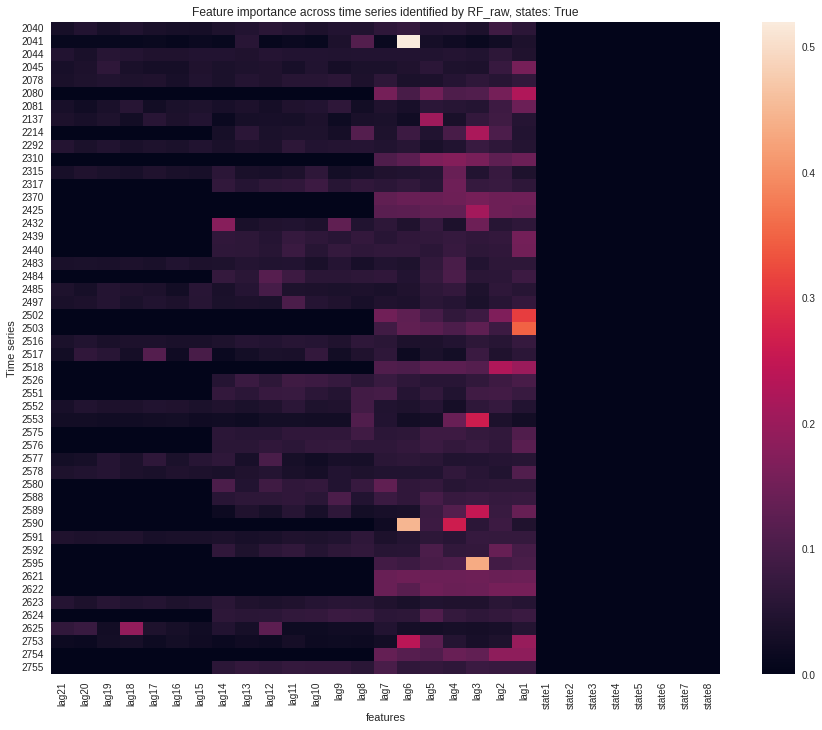

In [51]:
import matplotlib.pylab as pltlab
import seaborn as sns

model = 'RF_raw'

heatmap_grid = []

for id, play in agent_infos[model].items():
    if id not in played: continue

    fi = play['feature importances'][-1]
    if len(fi) == max_n_lag:
        heatmap_grid.append(fi + [0 for _ in range(n_states)])
    else:
        n_gap = max_n_lag - len(fi)
        heatmap_grid.append([0 for _ in range(n_gap)] + fi + [0 for _ in range(n_states)])

data = np.array(heatmap_grid)

plt.figure(figsize=(15, 12))
sns.heatmap(data, yticklabels=played, xticklabels=xticks)
plt.xlabel('features')
plt.ylabel('Time series')
plt.title(f'Feature importance across time series identified by {model}, states: {states}')
plt.show()

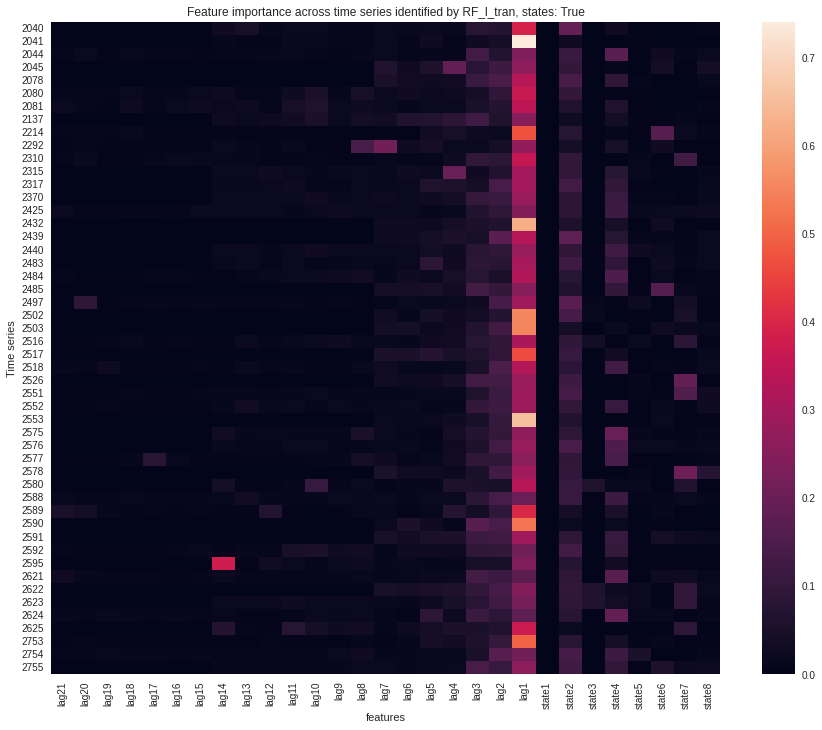

In [53]:
model = 'RF_l_tran'

heatmap_grid = []

for id, play in agent_infos[model].items():
    if id not in played: continue
    fi = play['feature importances'][-1]
    if len(fi) == max_n_lag + n_states:
        heatmap_grid.append(fi)
    else:
        n_gap = max_n_lag + n_states - len(fi)
        heatmap_grid.append([0 for _ in range(n_gap)] + fi)

data = np.array(heatmap_grid)

plt.figure(figsize=(15, 12))
sns.heatmap(data, yticklabels=played, xticklabels=xticks)
plt.xlabel('features')
plt.ylabel('Time series')
plt.title(f'Feature importance across time series identified by {model}, states: {states}')
plt.show()

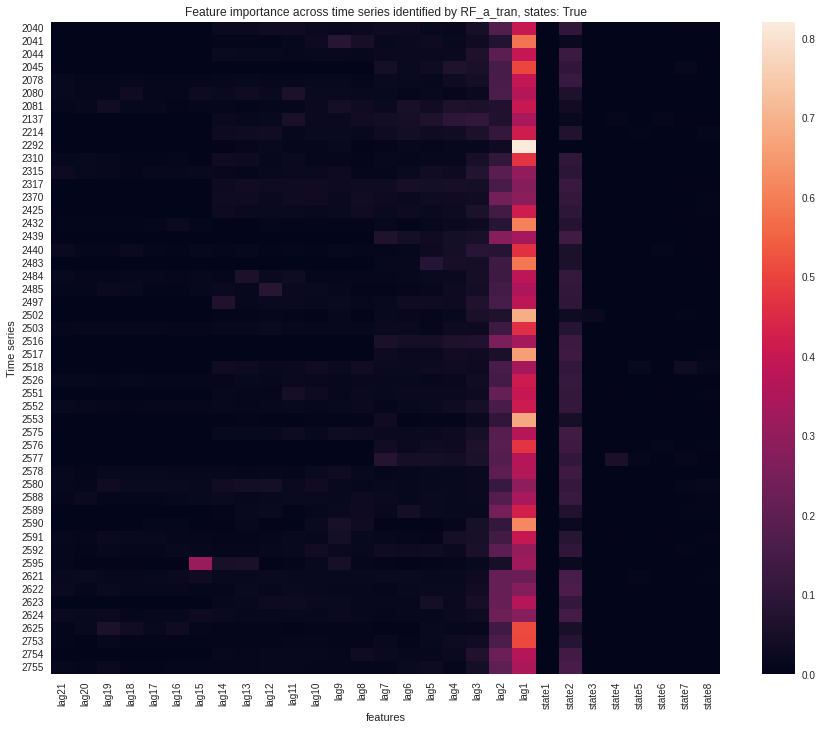

In [54]:
model = 'RF_a_tran'

heatmap_grid = []

for id, play in agent_infos[model].items():
    if id not in played: continue
    fi = play['feature importances'][-1]
    if len(fi) == max_n_lag + n_states:
        heatmap_grid.append(fi)
    else:
        n_gap = max_n_lag + n_states - len(fi)
        heatmap_grid.append([0 for _ in range(n_gap)] + fi)

data = np.array(heatmap_grid)

plt.figure(figsize=(15, 12))
sns.heatmap(data, yticklabels=played, xticklabels=xticks)
plt.xlabel('features')
plt.ylabel('Time series')
plt.title(f'Feature importance across time series identified by {model}, states: {states}')
plt.show()

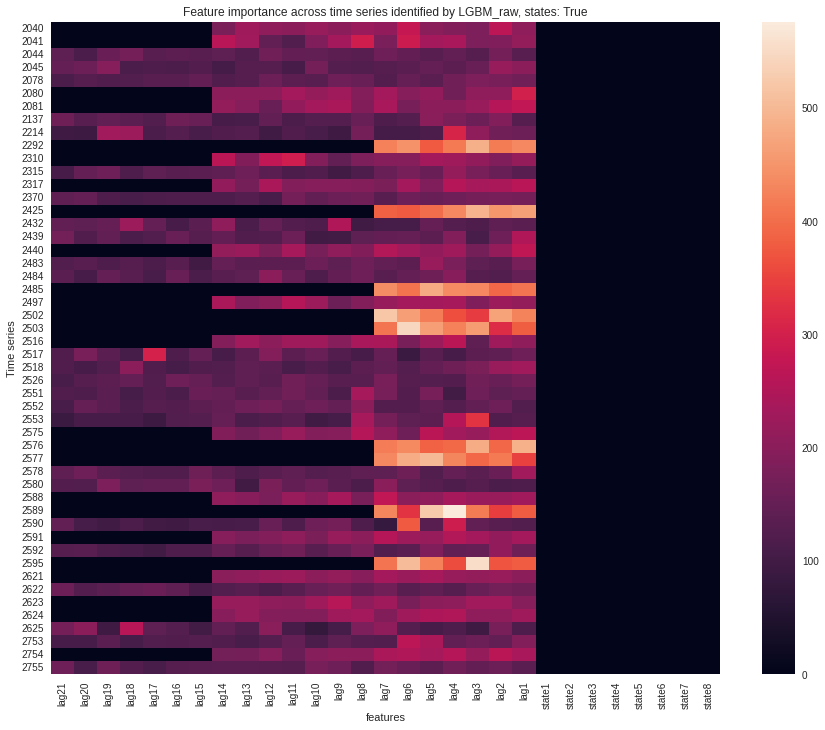

In [55]:
model = 'LGBM_raw'

heatmap_grid = []

for id, play in agent_infos[model].items():
    if id not in played: continue
    fi = play['feature importances'][-1]
    if len(fi) == max_n_lag:
        heatmap_grid.append(fi + [0 for _ in range(n_states)])
    else:
        n_gap = max_n_lag - len(fi)
        heatmap_grid.append([0 for _ in range(n_gap)] + fi + [0 for _ in range(n_states)])

data = np.array(heatmap_grid)

plt.figure(figsize=(15, 12))
sns.heatmap(data, yticklabels=played, xticklabels=xticks)
plt.xlabel('features')
plt.ylabel('Time series')
plt.title(f'Feature importance across time series identified by {model}, states: {states}')
plt.show()

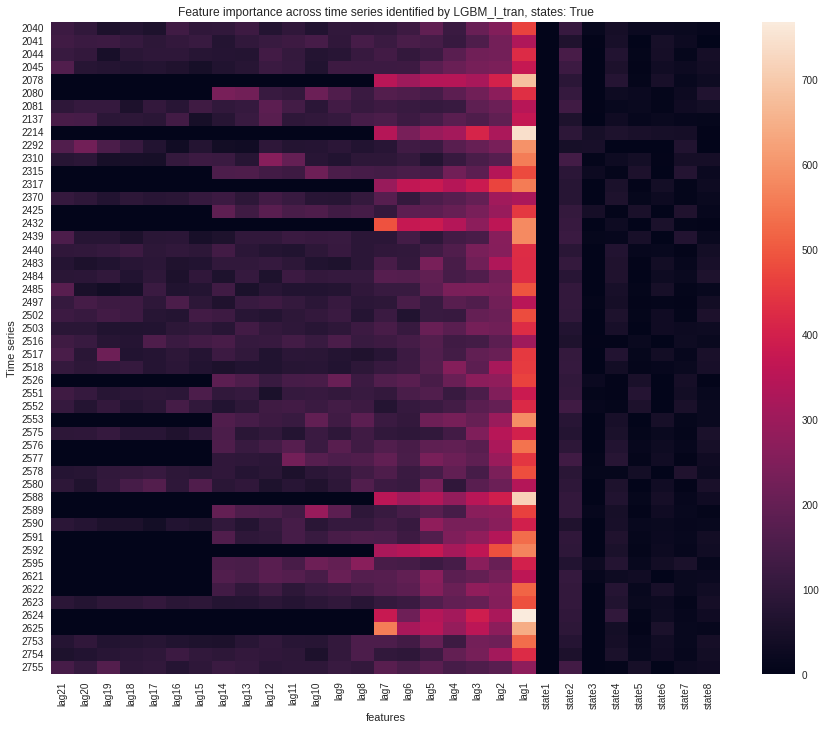

In [56]:
model = 'LGBM_l_tran'

heatmap_grid = []

for id, play in agent_infos[model].items():
    if id not in played: continue
    fi = play['feature importances'][-1]
    if len(fi) == max_n_lag + n_states:
        heatmap_grid.append(fi)
    else:
        n_gap = max_n_lag + n_states - len(fi)
        heatmap_grid.append([0 for _ in range(n_gap)] + fi)

data = np.array(heatmap_grid)

plt.figure(figsize=(15, 12))
sns.heatmap(data, yticklabels=played, xticklabels=xticks)
plt.xlabel('features')
plt.ylabel('Time series')
plt.title(f'Feature importance across time series identified by {model}, states: {states}')
plt.show()

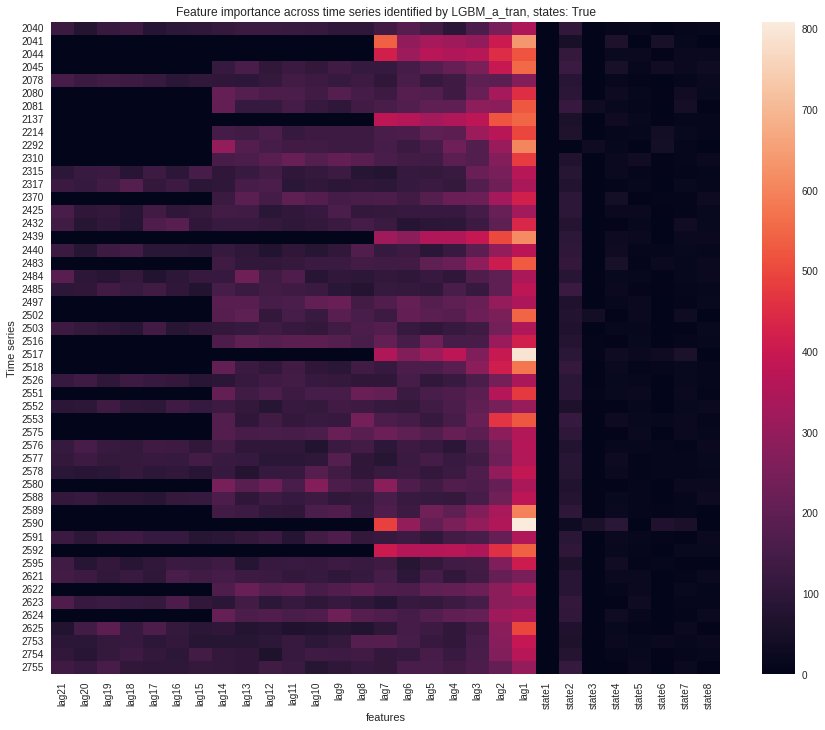

In [57]:
model = 'LGBM_a_tran'

heatmap_grid = []

for id, play in agent_infos[model].items():
    if id not in played: continue
    fi = play['feature importances'][-1]
    if len(fi) == max_n_lag + n_states:
        heatmap_grid.append(fi)
    else:
        n_gap = max_n_lag + n_states - len(fi)
        heatmap_grid.append([0 for _ in range(n_gap)] + fi)

data = np.array(heatmap_grid)

plt.figure(figsize=(15, 12))
sns.heatmap(data, yticklabels=played, xticklabels=xticks)
plt.xlabel('features')
plt.ylabel('Time series')
plt.title(f'Feature importance across time series identified by {model}, states: {states}')
plt.show()

# Linear regression model

In this section, we investigate the coefficients estimated by the linear regression model, in this case, EN. Note that since we fitted the linear model with intercept, we have an additional feature to the number of lags.

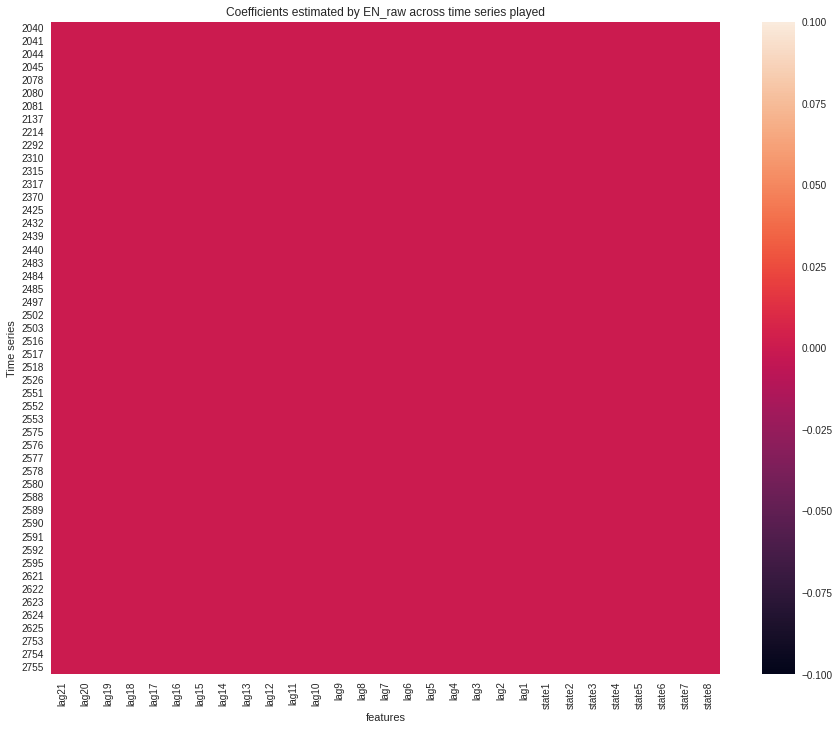

In [58]:
model = 'EN_raw'

# @NOTE: do not turn this to true, scale incomparable!!!
include_intercept = False

n_intercept = 1

heatmap_grid = []

for id, play in agent_infos[model].items():
    if id not in played: continue
    if include_intercept:
        coeffs = play['coeffs'][-1]
        n_intercept_c = n_intercept
    else:
        coeffs = play['coeffs'][-1][n_intercept:]
        n_intercept_c = 0
    if len(coeffs) == max_n_lag + n_intercept_c:
        heatmap_grid.append(coeffs + [0 for _ in range(n_states)])
    else:
        n_gap = max_n_lag  + n_intercept_c - len(coeffs)
        heatmap_grid.append([0 for _ in range(n_gap)] + coeffs + [0 for _ in range(n_states)])

data = np.array(heatmap_grid)

plt.figure(figsize=(15, 12))
sns.heatmap(data, yticklabels=played, xticklabels=xticks)
plt.xlabel('features')
plt.ylabel('Time series')
plt.title(f'Coefficients estimated by {model} across time series played')
plt.show()

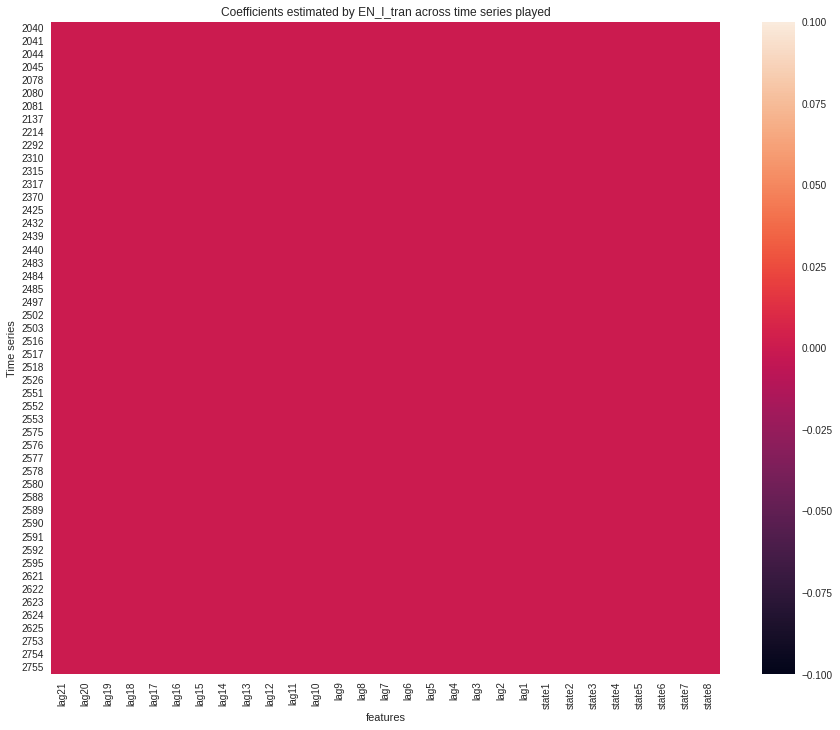

In [59]:
model = 'EN_l_tran'

# @NOTE: do not turn this to true, scale incomparable!!!
include_intercept = False

n_intercept = 1

heatmap_grid = []

for id, play in agent_infos[model].items():
    if id not in played: continue
    if include_intercept:
        coeffs = play['coeffs'][-1]
        n_intercept_c = n_intercept
    else:
        coeffs = play['coeffs'][-1][n_intercept:]
        n_intercept_c = 0
    if len(coeffs) == max_n_lag + n_intercept_c + n_states:
        heatmap_grid.append(coeffs)
    else:
        n_gap = max_n_lag + n_states + n_intercept_c - len(coeffs)
        heatmap_grid.append([0 for _ in range(n_gap)] + coeffs)

data = np.array(heatmap_grid)

plt.figure(figsize=(15, 12))
sns.heatmap(data, yticklabels=played, xticklabels=xticks)
plt.xlabel('features')
plt.ylabel('Time series')
plt.title(f'Coefficients estimated by {model} across time series played')
plt.show()

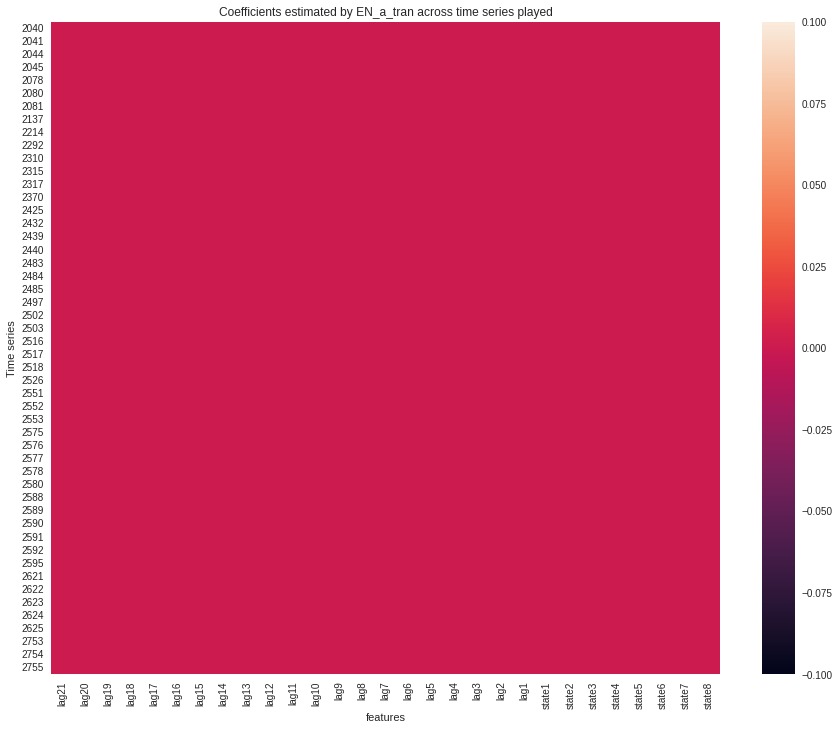

In [60]:
model = 'EN_a_tran'

# @NOTE: do not turn this to true, scale incomparable!!!
include_intercept = False

n_intercept = 1

heatmap_grid = []

for id, play in agent_infos[model].items():
    if id not in played: continue
    if include_intercept:
        coeffs = play['coeffs'][-1]
        n_intercept_c = n_intercept
    else:
        coeffs = play['coeffs'][-1][n_intercept:]
        n_intercept_c = 0
    if len(coeffs) == max_n_lag + n_intercept_c + n_states:
        heatmap_grid.append(coeffs)
    else:
        n_gap = max_n_lag + n_states + n_intercept_c - len(coeffs)
        heatmap_grid.append([0 for _ in range(n_gap)] + coeffs)

data = np.array(heatmap_grid)

plt.figure(figsize=(15, 12))
sns.heatmap(data, yticklabels=played, xticklabels=xticks)
plt.xlabel('features')
plt.ylabel('Time series')
plt.title(f'Coefficients estimated by {model} across time series played')
plt.show()

# Replicate the train to get more information

In the case of some of the information is not explicitly recorded from the experiment, there is a good chance it's implicitly contained in the recorded information. In this section, we derive the implicit information by replicating the traing using the information we have at hand.